In [1]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import os
import pandas as pd
import re
import sys
from tqdm.auto import tqdm

sys.path.append('..')
from dynamical_models import compute_VAR

# Load Data

In [2]:
dt = 0.01
subject_id = 'SC4001'
# subject_id = 'SC4401'
# subject_id = 'SC4591'
# subject_id = 'ST7011'

all_data_dir = os.path.join("/om/user/eisenaj/datasets/sleep/sleep-edf-database")

In [3]:
if subject_id[1] == 'C':
    data_folder = os.path.join(all_data_dir, 'sleep-cassette')
else: # subject_id[1] == 'T'
    data_folder = os.path.join(all_data_dir, 'sleep-telemetry')

eeg_regex = re.compile(f"{subject_id}" + ".{2}-PSG.edf")
hypnogram_regex = re.compile(f"{subject_id}" + ".{2}-Hypnogram.edf")

eeg_path = None
hypnogram_path = None
for file_name in os.listdir(data_folder):
    if eeg_regex.match(file_name):
        eeg_path = os.path.join(data_folder, file_name)
    elif hypnogram_regex.match(file_name):
        hypnogram_path = os.path.join(data_folder, file_name)

if eeg_path is None or hypnogram_path is None:
    print(f"Failed to find data for subject ID {subject_id}")

eeg = mne.io.read_raw_edf(eeg_path)
eeg_df = eeg.to_data_frame()
hypnogram = mne.read_annotations(hypnogram_path)
hypnogram_df = hypnogram.to_data_frame()

Extracting EDF parameters from /om/user/eisenaj/datasets/sleep/sleep-edf-database/sleep-cassette/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [4]:
start_time = 0
hypnogram_df['sleep_stage'] = [None]*len(hypnogram_df)
hypnogram_df['start_time'] = [None]*len(hypnogram_df)
hypnogram_df['end_time'] = [None]*len(hypnogram_df)
for i, row in hypnogram_df.iterrows():
    hypnogram_df.loc[i, 'sleep_stage'] = row.description[-1]
    hypnogram_df.loc[i, 'start_time'] = start_time
    hypnogram_df.loc[i, 'end_time'] = start_time + row.duration
    start_time += row.duration

In [5]:
eeg_df['sleep_stage'] = [None]*len(eeg_df)
place_in_session = 0
for i, row in tqdm(hypnogram_df.iterrows(), total=len(hypnogram_df)):
    if i == 0:
        indices = eeg_df.time <= place_in_session + int(row.duration/0.001)
    else:
        indices = np.logical_and(eeg_df.time > place_in_session, eeg_df.time <= place_in_session + int(row.duration/0.001))
    eeg_df.loc[indices, 'sleep_stage'] = row.description[-1]
    place_in_session += int(row.duration/0.001)

  0%|          | 0/154 [00:00<?, ?it/s]

## Window Selection

In [6]:
all_eeg = np.zeros((len(eeg_df), 2))
all_eeg[:, 0] = eeg_df['EEG Fpz-Cz']
all_eeg[:, 1] = eeg_df['EEG Pz-Oz']

In [ ]:
VAR_results = {}
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.5, 0.5)]

In [50]:
windows = [0.1, 0.2, 0.3, 0.4]

In [51]:
for window in windows:
    print(f"now computing window = {window}")
    stride = window

    num_windows = int(np.floor((all_eeg.shape[0]-int(window/dt))/int(stride/dt))+1)

    all_results = []
    for i in tqdm(range(num_windows)):
        start_ind = int(i*stride/dt)
        end_ind = int((i*stride + window)/dt)
        window_data = all_eeg[start_ind:end_ind]

        try:
            results = compute_VAR(window_data)
            results['start_time'] = i*stride
            results['start_time_ms'] = i*stride*1000
            results['start_ind'] = start_ind
            results['end_time'] = i*stride + window
            results['end_time_ms'] = (i*stride + window)*1000
            results['end_ind'] = end_ind
            all_results.append(results)
        except:
            pass
            # sometimes this doesn't work because the EEG isn't aligned at the beginning/end
    VAR_results[window] = pd.DataFrame(all_results)

now computing window = 0.1


  0%|          | 0/795000 [00:00<?, ?it/s]

now computing window = 0.2


  0%|          | 0/397500 [00:00<?, ?it/s]

now computing window = 0.3


  0%|          | 0/265000 [00:00<?, ?it/s]

now computing window = 0.4


  0%|          | 0/198750 [00:00<?, ?it/s]

In [ ]:
T_pred = 10

predictions = {}
true_vals = {}
step_mse = {}

In [52]:
for window in windows:
    stride = window
    print(f"Now computing window = {window}")
    predictions[window] = np.zeros((len(VAR_results[window]) - 1, T_pred, all_eeg.shape[1]))
    true_vals[window] = np.zeros(predictions[window].shape)

    for i in tqdm(range(predictions[window].shape[0])):
        row = VAR_results[window].iloc[i]
        start_step = int(stride*i/dt)
        x0 = all_eeg[start_step + int(window/dt) - 1]

        for t in range(T_pred):
            if t == 0:
                predictions[window][i, t] = np.hstack([[1], x0]) @ row.A_mat_with_bias
            else:
                predictions[window][i, t] = np.hstack([[1], predictions[window][i, t - 1]]) @ row.A_mat_with_bias

        true_vals[window][i] = all_eeg[start_step + int(window/dt):start_step + int(window/dt) + T_pred]

    step_mse[window] = ((predictions[window] - true_vals[window])**2).mean(axis=2)

Now computing window = 0.1


  0%|          | 0/794980 [00:00<?, ?it/s]

Now computing window = 0.2


  0%|          | 0/397499 [00:00<?, ?it/s]

Now computing window = 0.3


  0%|          | 0/264999 [00:00<?, ?it/s]

Now computing window = 0.4


  0%|          | 0/198749 [00:00<?, ?it/s]

In [53]:
windows = [0.1, 0.2, 0.3, 0.4]
windows.extend([int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.5, 0.5)])
windows.extend(np.arange(11, 31))

In [54]:
pred_steps = 10
window_mses = [step_mse[window][pred_steps - 1].mean() for window in windows]

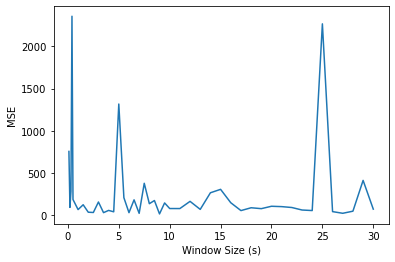

In [57]:
plt.plot(windows, window_mses)
plt.xlabel("Window Size (s)")
plt.ylabel("MSE")
plt.show()

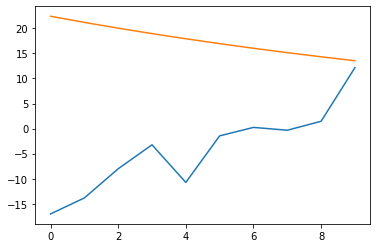

In [46]:
window = 30
window_ind = 2000
eeg_ind = 0
plt.plot(all_eeg[(window_ind+1)*window:(window_ind+1)*window + T_pred, eeg_ind], label='true')
plt.plot(predictions[window][window_ind, :, eeg_ind], label='predicted')

plt.show()

In [48]:
VAR_results[30]

,explained_variance,A_mat,A_mat_with_bias,eigs,criticality_inds,sigma2_ML,AIC,sigma_norm,start_time,start_time_ms,start_ind,end_time,end_time_ms,end_ind
0,None,"[[0.9634810317792123, 0.0736344857285943], [0....","[[0.04999137008040016, -0.05457139275295817], ...","[0.971901972563386, 0.8327254238459885]","[0.971901972563386, 0.8327254238459885]",7.111462,5887.123647,80.105940,0,0,0,30,30000,3000
1,None,"[[0.8662883042193071, 0.11373429582323705], [0...","[[-0.02446621841568477, -0.20211566475367576],...","[0.8777796028843405, 0.43360298956441745]","[0.8777796028843405, 0.43360298956441745]",10.843944,7152.820337,164.716012,30,30000,3000,60,60000,6000
2,None,"[[0.9261279878976012, 0.10195944189119925], [0...","[[0.10660965605344996, -0.08004120955060712], ...","[0.9385538726622957, 0.7996315665933637]","[0.9385538726622957, 0.7996315665933637]",9.845107,6862.923634,129.672443,60,60000,6000,90,90000,9000
3,None,"[[0.9202684869610434, 0.009342802680784438], [...","[[-0.014479506923611997, -0.02158316084422802]...","[0.9203752299344727, 0.8474222857765868]","[0.9203752299344727, 0.8474222857765868]",7.346234,5984.563445,49.829130,90,90000,9000,120,120000,12000
4,None,"[[0.9170204482704877, -0.01749802590883481], [...","[[0.01707518456586975, -0.022163892092107954],...","[0.9156460899359619, 0.8581634104042627]","[0.9156460899359619, 0.8581634104042627]",7.251713,5945.713037,46.604088,120,120000,12000,150,150000,15000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2645,None,"[[0.9036265867243417, 0.03151121082213749], [0...","[[0.005894330748547966, -0.13187238712455784],...","[0.9053785995339952, 0.7007772102641588]","[0.9053785995339952, 0.7007772102641588]",7.822563,6173.036623,83.483352,79350,79350000,7935000,79380,79380000,7938000
2646,None,"[[0.9202018342113728, 0.03762757674286538], [0...","[[0.025385303079737038, -0.025324169254399065]...","[0.9230035000892225, 0.6202405338311662]","[0.9230035000892225, 0.6202405338311662]",9.291515,6689.304890,106.225142,79380,79380000,7938000,79410,79410000,7941000
2647,None,"[[0.887373010062635, 0.05580370336791244], [0....","[[0.06372547840476783, -0.06725856481117984], ...","[0.8970199072624105, 0.8473292657163403]","[0.8970199072624105, 0.8473292657163403]",6.957875,5821.622163,75.813816,79410,79410000,7941000,79440,79440000,7944000
2648,None,"[[0.9168085979409996, 0.09424491180983939], [0...","[[0.021953546781374764, -0.10796103080458075],...","[0.9327143716550411, 0.6885561685577026]","[0.9327143716550411, 0.6885561685577026]",8.480773,6415.404804,91.014728,79440,79440000,7944000,79470,79470000,7947000
